In [1]:
import sys, os
import theano
import scipy
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
import scanpy as sc
import pandas as pd
sc.settings.autosave=False
sc.settings.autoshow=True
import anndata
import re
import copy


# ambiaint test

/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

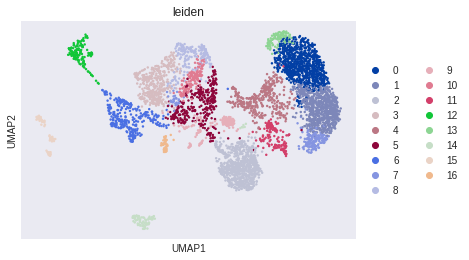

In [2]:
#limit for memory
maxgenes=5000
ncells=5000
headpath=os.path.expanduser("/home/mt/Downloads/")
h5adpath=os.path.join(headpath,'MultiseqRaw.h5ad')
#Load any 10x dataset

adata=sc.read_h5ad(h5adpath)
adata._inplace_subset_obs(adata.obs['batch']=='0')
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
cells=np.random.choice(adata.obs.index,ncells,replace=False)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(maxgenes,4000))
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'n_counts')

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata,color='leiden')
clusters=adata.obs['leiden']

In [3]:
#Reload fresh dataset
adata=sc.read_h5ad(h5adpath)
adata._inplace_subset_obs(cells)
#limit genes to top maxgenes expressed 
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
adata.obs['leiden']=clusters

In [4]:
#mean and sd of ambient gaussian
ambmu,ambsd=2.0,.4
#K topics/modules
K=10

In [5]:
#Get mixtures of genes in each cluster
clusterphis=[]
for c in set(clusters):
    clusterphis.append(adata[adata.obs['leiden']==c,:].X.sum(0).A1)
clusterphis=np.matrix(clusterphis)
clusterphis=clusterphis/(clusterphis.sum(1))

#Construct an ambient fraction that is mixture of clusters
def Stick_Breaking(num_weights, alpha):
    betas = np.random.beta(1, alpha, size=num_weights)
    betas[1:] *= np.cumprod(1 - betas[:-1])
    return betas
ambprops=Stick_Breaking(len(set(clusters)),1)
np.random.shuffle(ambprops)
ambcounts=[int(x) for x in 10**np.random.normal(ambmu,ambsd,adata.shape[0])]
print(ambprops)
sum(ambprops)


[6.60394051e-04 2.66155900e-01 4.35223656e-05 4.40153616e-05
 1.65631665e-05 6.12078214e-05 4.22625681e-02 3.35577969e-06
 1.42381369e-05 1.47728267e-04 5.66849201e-05 7.32795346e-05
 2.01665883e-01 4.37720963e-01 4.60273749e-02 1.11275702e-04
 4.93475023e-03]


0.9999997044399623

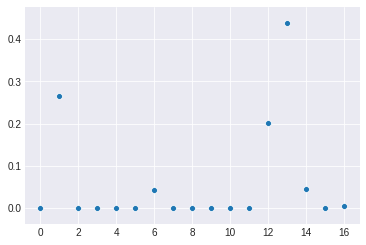

In [6]:
sns.scatterplot(list(range(len(ambprops))),ambprops)

In [7]:
phiAmbient=(ambprops*clusterphis).A1
phiAmbient=phiAmbient/phiAmbient.sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient))
tmpmat=scipy.sparse.csr_matrix(adata.shape)
for ci,c in tqdm(enumerate(adata.obs.index)):
    countadd=Counter(np.random.choice(list(range(len(phiAmbient))),replace=True,size=ambcounts[ci],p=phiAmbient))
    tmpmat[ci,list(countadd.keys())]=list(countadd.values())

5000it [00:38, 64.92it/s]


In [8]:
adata.X.sum()

13704315.0

In [9]:
adata.X=adata.X+tmpmat

In [10]:
#(adata.X-tmpmat).sum()
import copy

In [11]:
np.corrcoef(tmpmat.sum(0).A1,phiAmbient)
freshadata=adata.copy()
ambcountsorig=copy.deepcopy(ambcounts)
phiAmbientOrig=copy.deepcopy(phiAmbient)


Number of tokens in training set = 39520.0
Sparsity = 0.9232
1.0 1.0
50 50


Finished [100%]: Average Loss = 160.74


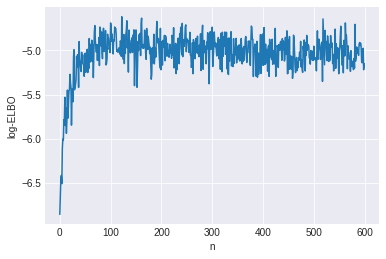

Correlation between actual ambient and predicted ambient counts
0.26486059364315423
 actual ambient and predicted ambient count distributions


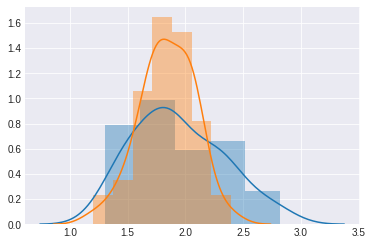

Actual vs predicted


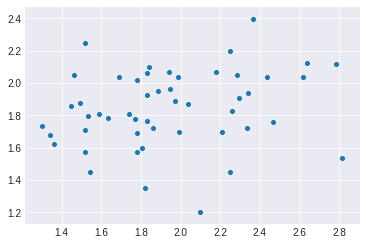

1.0 39520.0
50 50


Finished [100%]: Average Loss = 2,826.1


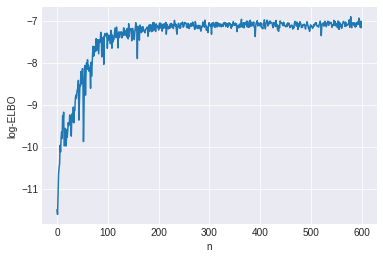

Correlation between actual ambient and predicted ambient counts
-0.03203881319549943
 actual ambient and predicted ambient count distributions


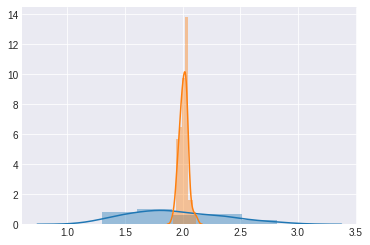

Actual vs predicted


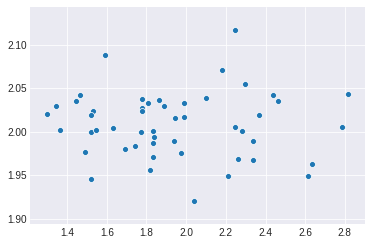

Trying to set attribute `.obs` of view, making a copy.


1.0 50
50 50


Finished [100%]: Average Loss = 204.72


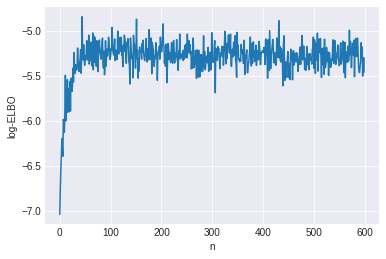

Correlation between actual ambient and predicted ambient counts
0.33647958985678184
 actual ambient and predicted ambient count distributions


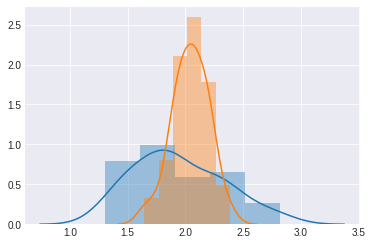

Actual vs predicted


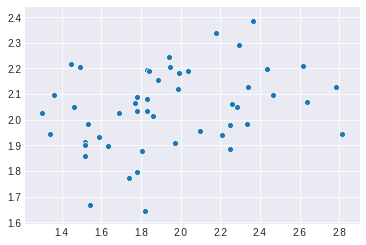

Trying to set attribute `.obs` of view, making a copy.


1.0 50
50 50


Finished [100%]: Average Loss = 209.41


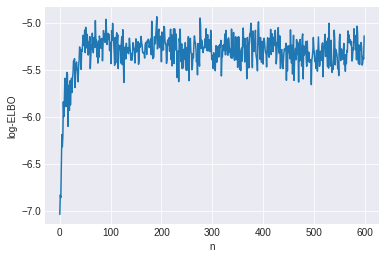

Correlation between actual ambient and predicted ambient counts
0.1877176641199577
 actual ambient and predicted ambient count distributions


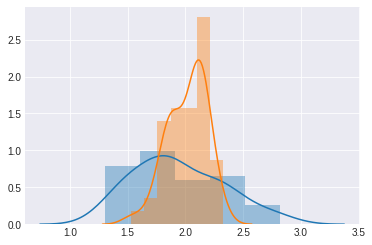

Actual vs predicted


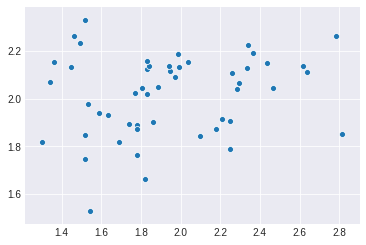

Trying to set attribute `.obs` of view, making a copy.


1.0 1976000.0
50 50


Finished [100%]: Average Loss = 94,641


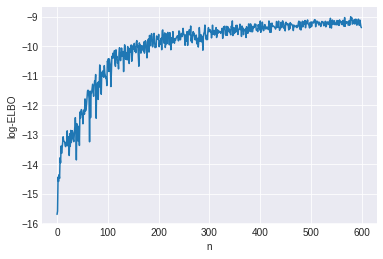

Correlation between actual ambient and predicted ambient counts
-0.04178975634195578
 actual ambient and predicted ambient count distributions


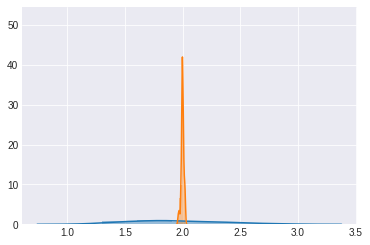

Actual vs predicted


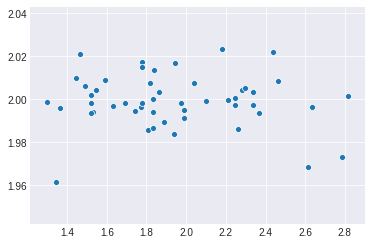

Trying to set attribute `.obs` of view, making a copy.


1.0 98800000.0
50 50


Finished [100%]: Average Loss = 4.6964e+06


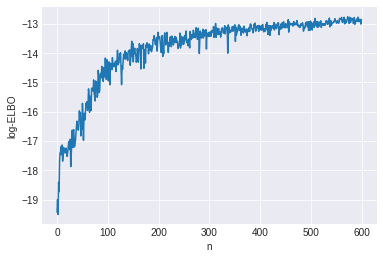

Correlation between actual ambient and predicted ambient counts
0.25852007888782297
 actual ambient and predicted ambient count distributions


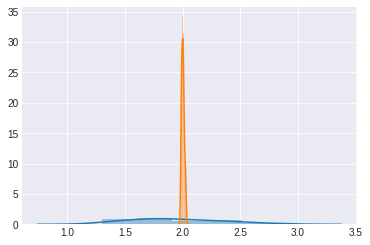

Actual vs predicted


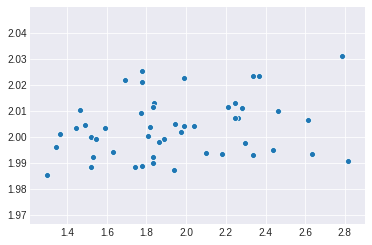

Trying to set attribute `.obs` of view, making a copy.


39520.0 1.0
50 50


Finished [100%]: Average Loss = 1.362e+05


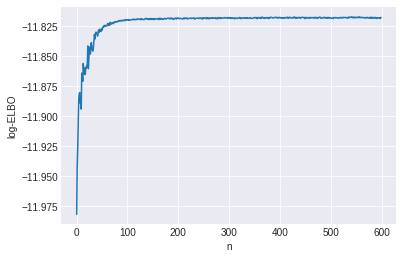

Correlation between actual ambient and predicted ambient counts
0.19261715279453182
 actual ambient and predicted ambient count distributions


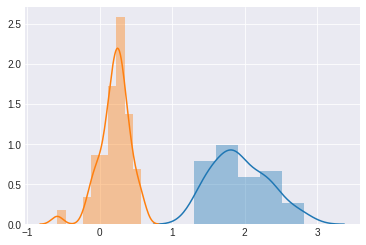

Actual vs predicted


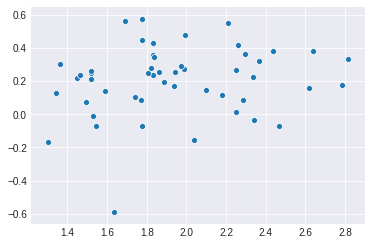

Trying to set attribute `.obs` of view, making a copy.


39520.0 39520.0
50 50


Finished [100%]: Average Loss = 1.4161e+05


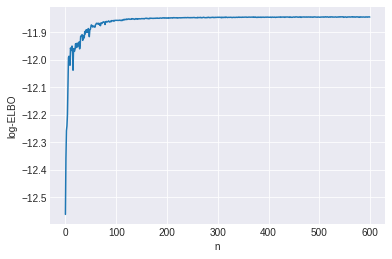

Correlation between actual ambient and predicted ambient counts
0.09467541350574118
 actual ambient and predicted ambient count distributions


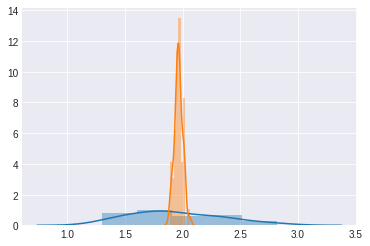

Actual vs predicted


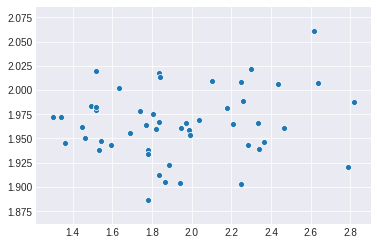

Trying to set attribute `.obs` of view, making a copy.


39520.0 50
50 50


Finished [100%]: Average Loss = 1.3648e+05


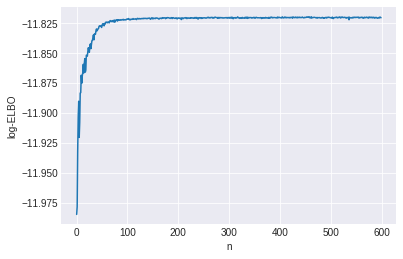

Correlation between actual ambient and predicted ambient counts
0.008165814457623542
 actual ambient and predicted ambient count distributions


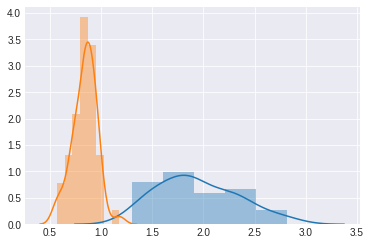

Actual vs predicted


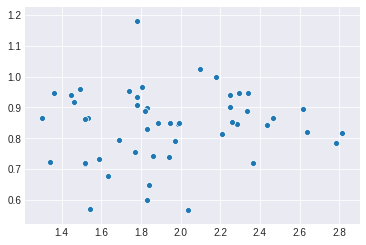

Trying to set attribute `.obs` of view, making a copy.


39520.0 50
50 50


Finished [100%]: Average Loss = 1.3649e+05


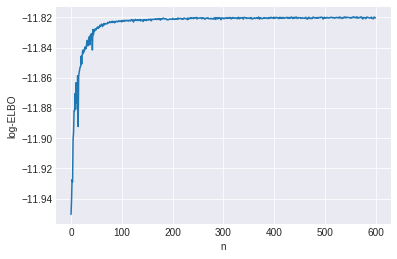

Correlation between actual ambient and predicted ambient counts
-0.10428225404412182
 actual ambient and predicted ambient count distributions


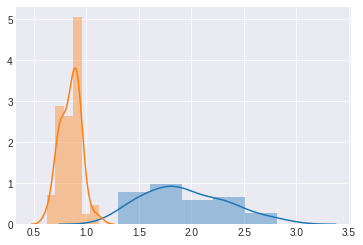

Actual vs predicted


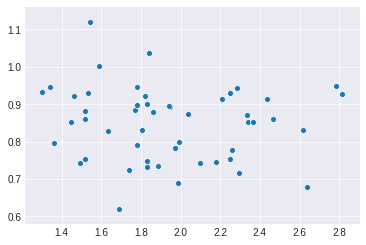

Trying to set attribute `.obs` of view, making a copy.


39520.0 1976000.0
50 50


Finished [100%]: Average Loss = 2.2505e+05


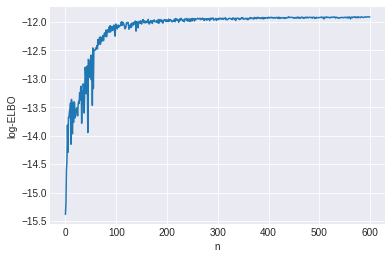

Correlation between actual ambient and predicted ambient counts
-0.0030741889722818044
 actual ambient and predicted ambient count distributions


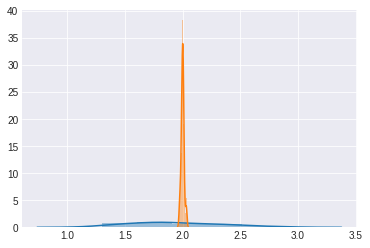

Actual vs predicted


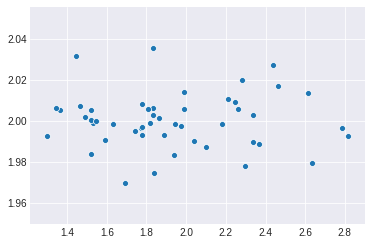

Trying to set attribute `.obs` of view, making a copy.


39520.0 98800000.0
50 50


Finished [100%]: Average Loss = 3.9808e+06


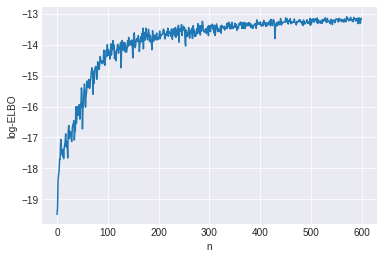

Correlation between actual ambient and predicted ambient counts
-0.04822633950267081
 actual ambient and predicted ambient count distributions


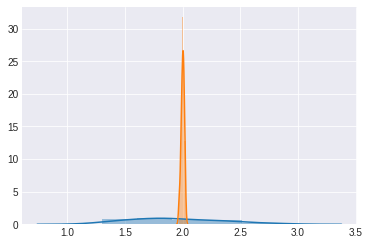

Actual vs predicted


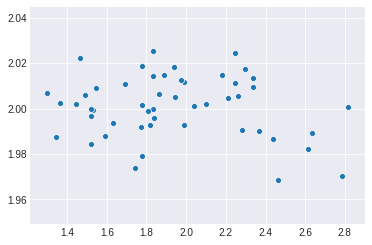

Trying to set attribute `.obs` of view, making a copy.


50 1.0
50 50


Finished [100%]: Average Loss = 356.17


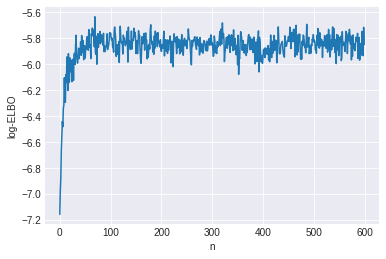

Correlation between actual ambient and predicted ambient counts
0.2224463926662037
 actual ambient and predicted ambient count distributions


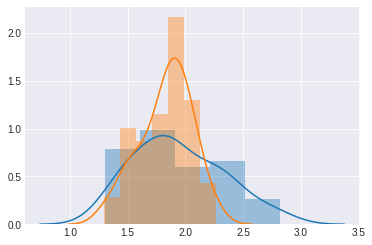

Actual vs predicted


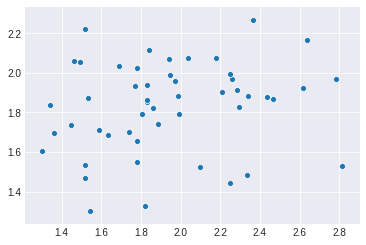

Trying to set attribute `.obs` of view, making a copy.


50 39520.0
50 50


Finished [100%]: Average Loss = 2,599.6


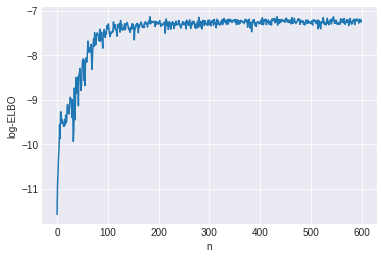

Correlation between actual ambient and predicted ambient counts
-0.08540481238620387
 actual ambient and predicted ambient count distributions


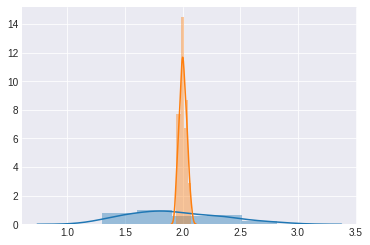

Actual vs predicted


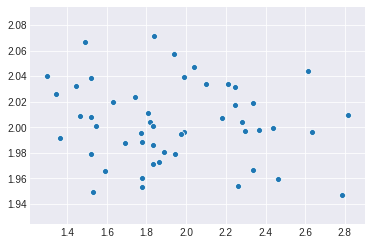

Trying to set attribute `.obs` of view, making a copy.


50 50
50 50


Finished [100%]: Average Loss = 405.55


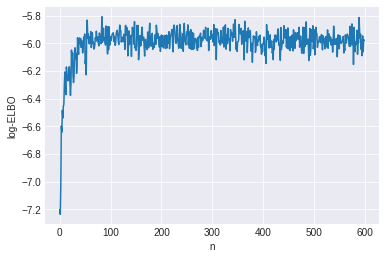

Correlation between actual ambient and predicted ambient counts
0.1446309843053205
 actual ambient and predicted ambient count distributions


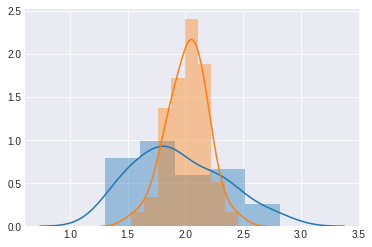

Actual vs predicted


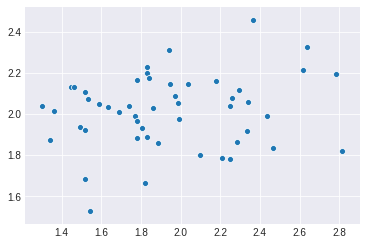

Trying to set attribute `.obs` of view, making a copy.


50 50
50 50


Finished [100%]: Average Loss = 405.96


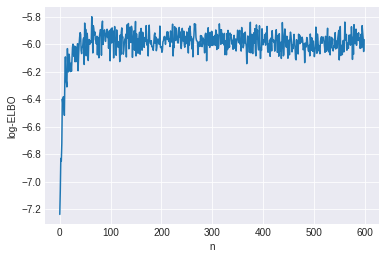

Correlation between actual ambient and predicted ambient counts
0.46612390292222855
 actual ambient and predicted ambient count distributions


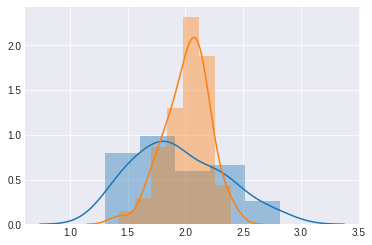

Actual vs predicted


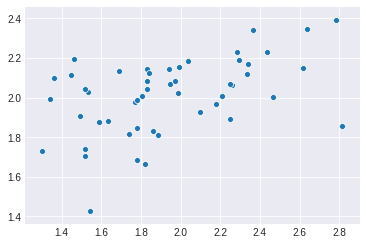

Trying to set attribute `.obs` of view, making a copy.


50 1976000.0
50 50


Finished [100%]: Average Loss = 65,779


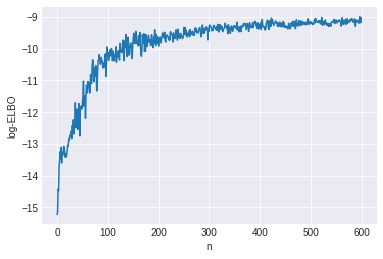

Correlation between actual ambient and predicted ambient counts
-0.018733339049842247
 actual ambient and predicted ambient count distributions


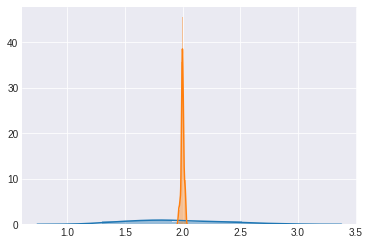

Actual vs predicted


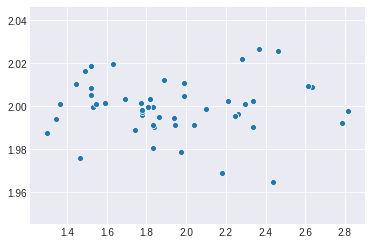

Trying to set attribute `.obs` of view, making a copy.


50 98800000.0
50 50


Finished [100%]: Average Loss = 3.8281e+06


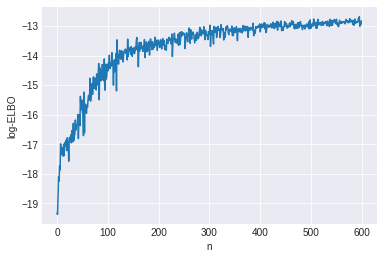

Correlation between actual ambient and predicted ambient counts
0.06888104666018918
 actual ambient and predicted ambient count distributions


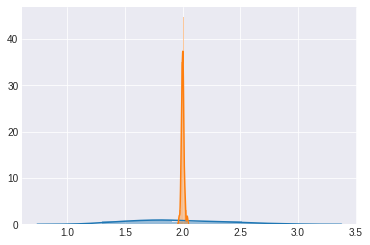

Actual vs predicted


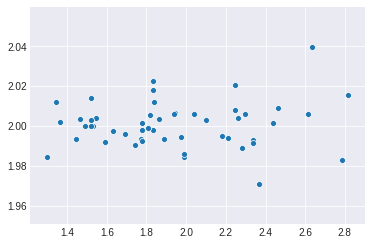

Trying to set attribute `.obs` of view, making a copy.


50 1.0
50 50


Finished [100%]: Average Loss = 357.73


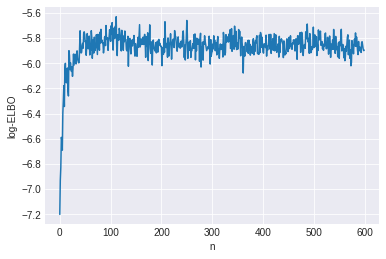

Correlation between actual ambient and predicted ambient counts
0.2813843593691689
 actual ambient and predicted ambient count distributions


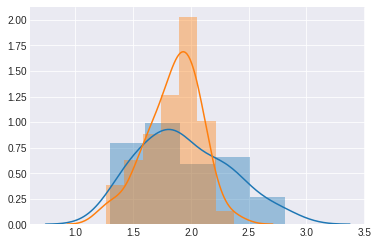

Actual vs predicted


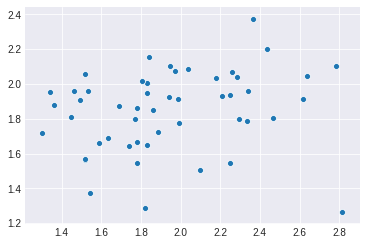

Trying to set attribute `.obs` of view, making a copy.


50 39520.0
50 50


Finished [100%]: Average Loss = 2,870.8


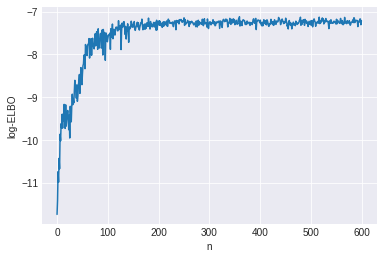

Correlation between actual ambient and predicted ambient counts
0.012056584875667702
 actual ambient and predicted ambient count distributions


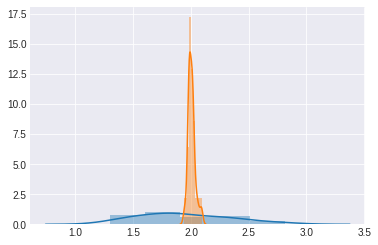

Actual vs predicted


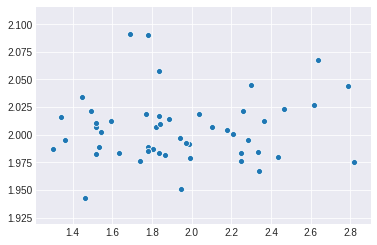

Trying to set attribute `.obs` of view, making a copy.


50 50
50 50


Finished [100%]: Average Loss = 407.4


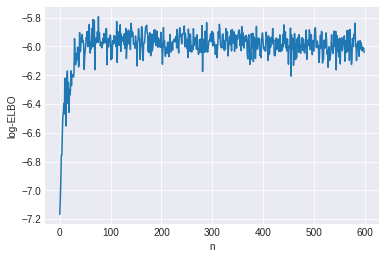

Correlation between actual ambient and predicted ambient counts
0.31145377025430027
 actual ambient and predicted ambient count distributions


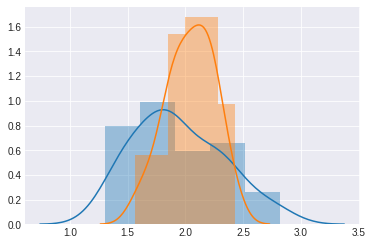

Actual vs predicted


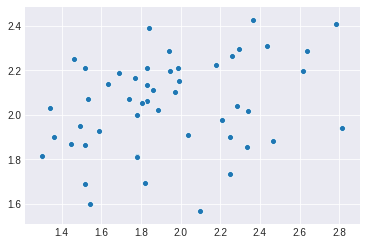

Trying to set attribute `.obs` of view, making a copy.


50 50
50 50


Finished [100%]: Average Loss = 403.92


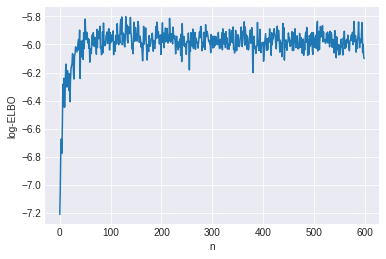

Correlation between actual ambient and predicted ambient counts
0.40488029449005203
 actual ambient and predicted ambient count distributions


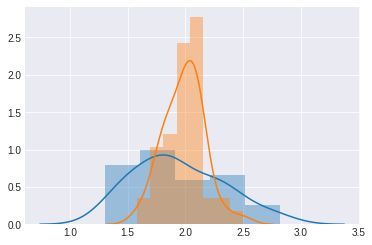

Actual vs predicted


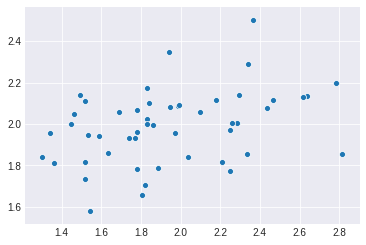

Trying to set attribute `.obs` of view, making a copy.


50 1976000.0
50 50


Finished [100%]: Average Loss = 78,137


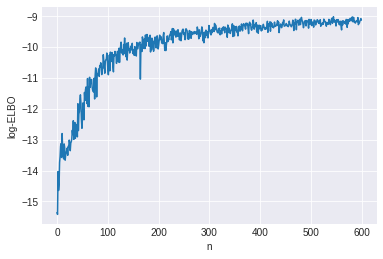

Correlation between actual ambient and predicted ambient counts
0.07800754517165077
 actual ambient and predicted ambient count distributions


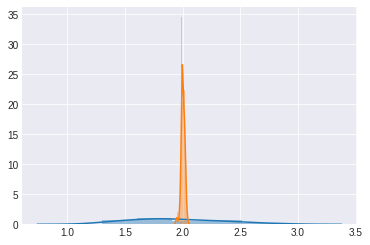

Actual vs predicted


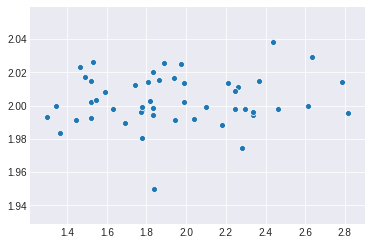

Trying to set attribute `.obs` of view, making a copy.


50 98800000.0
50 50


Finished [100%]: Average Loss = 4.3206e+06


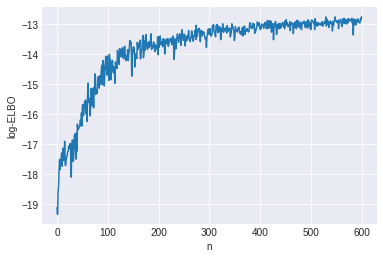

Correlation between actual ambient and predicted ambient counts
0.2335903276907252
 actual ambient and predicted ambient count distributions


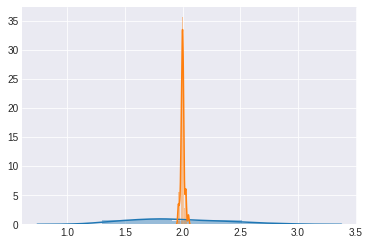

Actual vs predicted


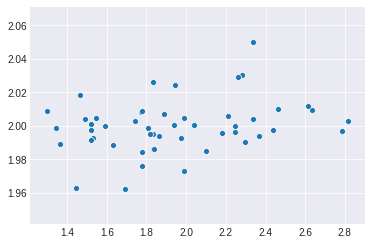

Trying to set attribute `.obs` of view, making a copy.


1976000.0 1.0
50 50


Finished [100%]: Average Loss = 6.7152e+06


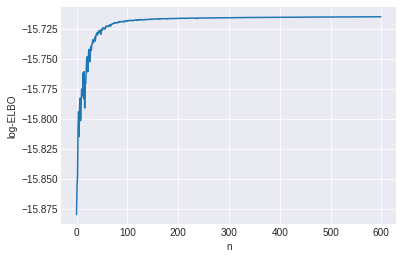

Correlation between actual ambient and predicted ambient counts
0.29075102889409005
 actual ambient and predicted ambient count distributions


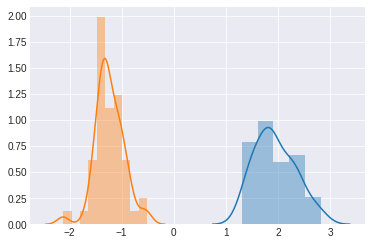

Actual vs predicted


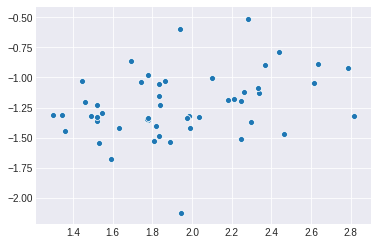

Trying to set attribute `.obs` of view, making a copy.


1976000.0 39520.0
50 50


Finished [100%]: Average Loss = 6.7921e+06


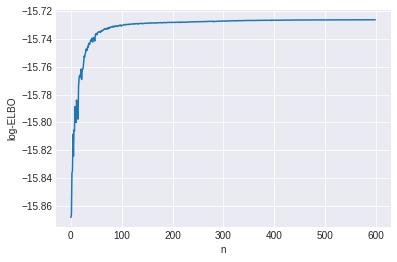

Correlation between actual ambient and predicted ambient counts
-0.09539592654611975
 actual ambient and predicted ambient count distributions


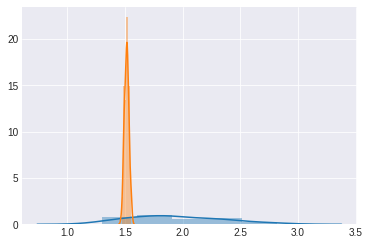

Actual vs predicted


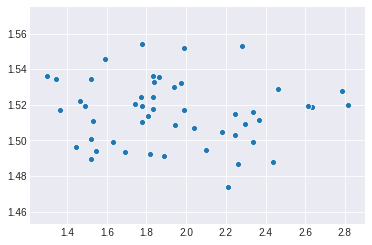

Trying to set attribute `.obs` of view, making a copy.


1976000.0 50
50 50


Finished [100%]: Average Loss = 6.7088e+06


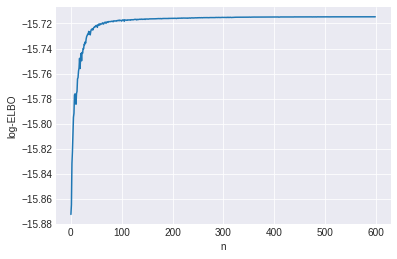

Correlation between actual ambient and predicted ambient counts
-0.014458295010262861
 actual ambient and predicted ambient count distributions


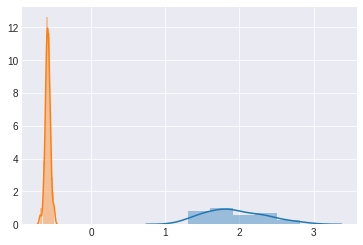

Actual vs predicted


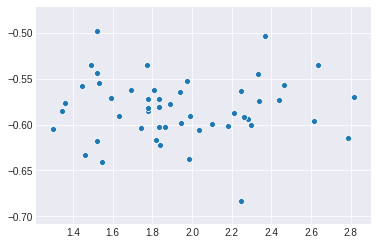

Trying to set attribute `.obs` of view, making a copy.


1976000.0 50
50 50


Finished [100%]: Average Loss = 6.7056e+06


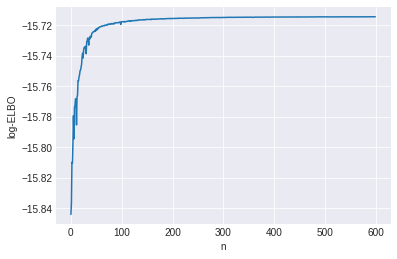

Correlation between actual ambient and predicted ambient counts
0.07214737244323859
 actual ambient and predicted ambient count distributions


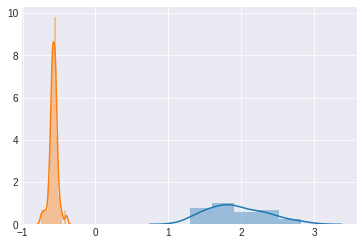

Actual vs predicted


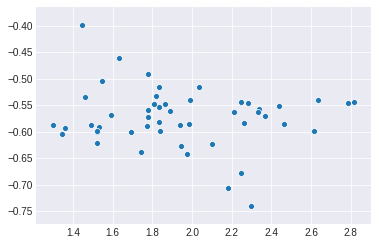

Trying to set attribute `.obs` of view, making a copy.


1976000.0 1976000.0
50 50


Finished [100%]: Average Loss = 6.9693e+06


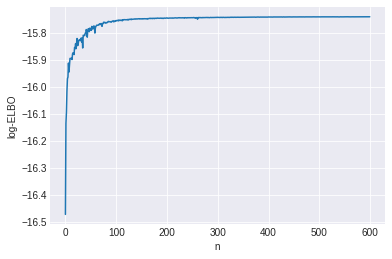

Correlation between actual ambient and predicted ambient counts
0.14563970256185046
 actual ambient and predicted ambient count distributions


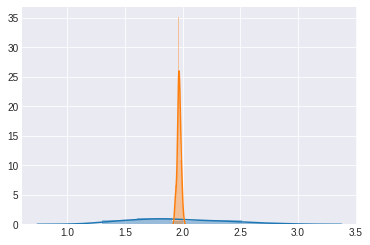

Actual vs predicted


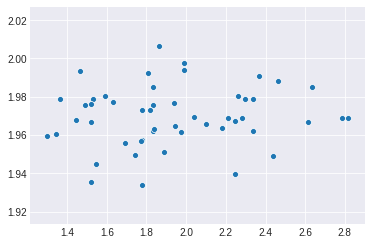

Trying to set attribute `.obs` of view, making a copy.


1976000.0 98800000.0
50 50


Finished [100%]: Average Loss = 1.1148e+07


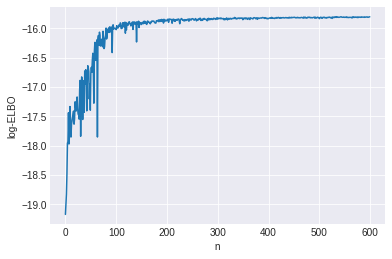

Correlation between actual ambient and predicted ambient counts
0.047890100083827485
 actual ambient and predicted ambient count distributions


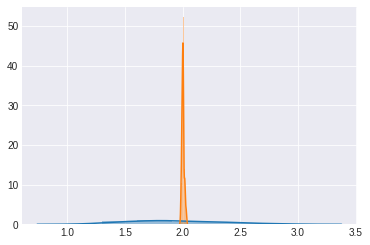

Actual vs predicted


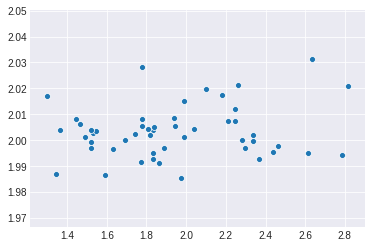

Trying to set attribute `.obs` of view, making a copy.


98800000.0 1.0
50 50


Finished [100%]: Average Loss = 3.3521e+08


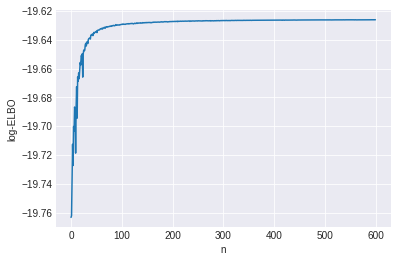

Correlation between actual ambient and predicted ambient counts
0.0376107807077602
 actual ambient and predicted ambient count distributions


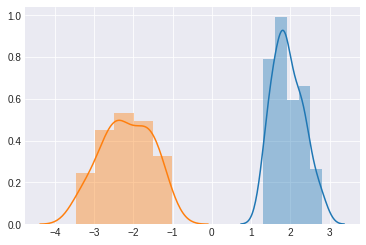

Actual vs predicted


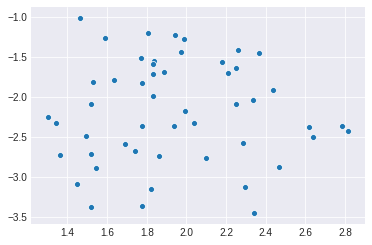

Trying to set attribute `.obs` of view, making a copy.


98800000.0 39520.0
50 50


Finished [100%]: Average Loss = 3.3602e+08


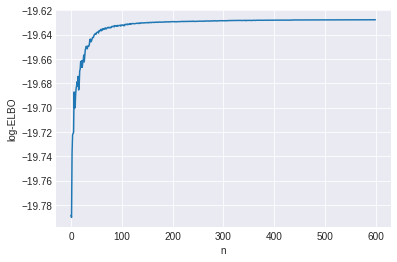

Correlation between actual ambient and predicted ambient counts
-0.06523044725560453
 actual ambient and predicted ambient count distributions


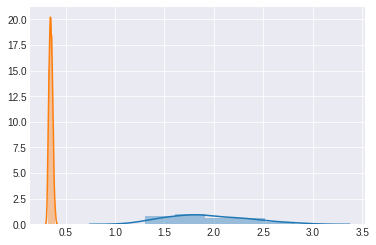

Actual vs predicted


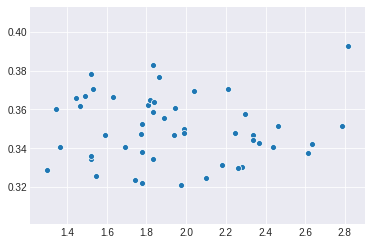

Trying to set attribute `.obs` of view, making a copy.


98800000.0 50
50 50


Finished [100%]: Average Loss = 3.3567e+08


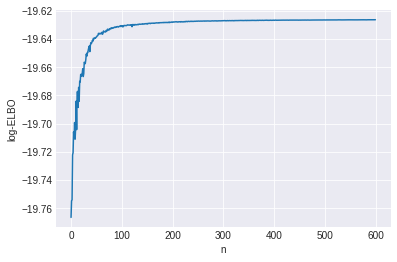

Correlation between actual ambient and predicted ambient counts
0.14083628229266015
 actual ambient and predicted ambient count distributions


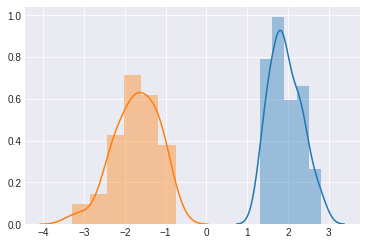

Actual vs predicted


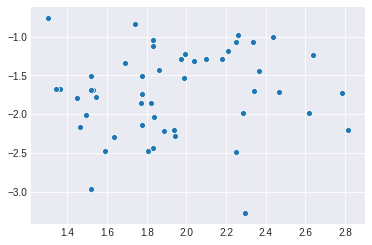

Trying to set attribute `.obs` of view, making a copy.


98800000.0 50
50 50


Finished [100%]: Average Loss = 3.3539e+08


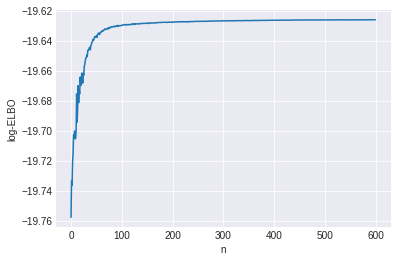

Correlation between actual ambient and predicted ambient counts
0.13805029853652978
 actual ambient and predicted ambient count distributions


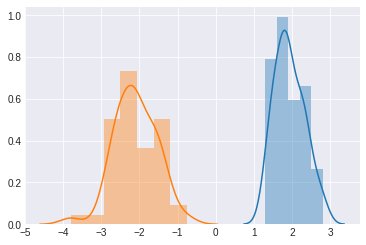

Actual vs predicted


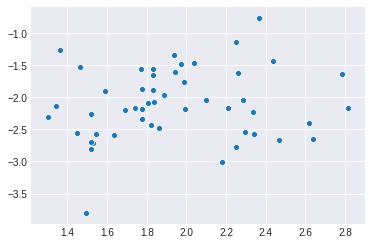

Trying to set attribute `.obs` of view, making a copy.


98800000.0 1976000.0
50 50


Finished [100%]: Average Loss = 3.3941e+08


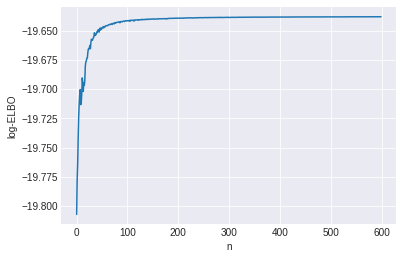

Correlation between actual ambient and predicted ambient counts
0.1351682463750156
 actual ambient and predicted ambient count distributions


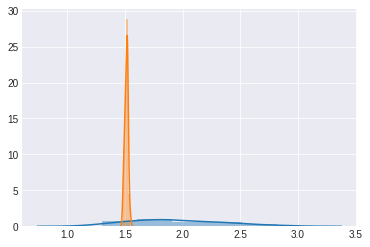

Actual vs predicted


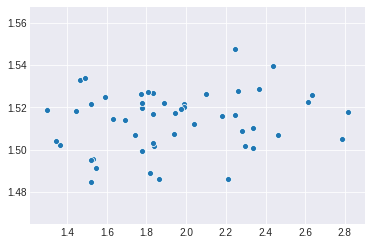

Trying to set attribute `.obs` of view, making a copy.


98800000.0 98800000.0
50 50


Finished [100%]: Average Loss = 3.4816e+08


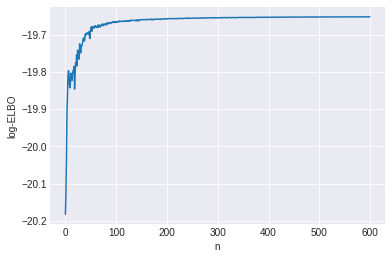

Correlation between actual ambient and predicted ambient counts
0.17133800100201868
 actual ambient and predicted ambient count distributions


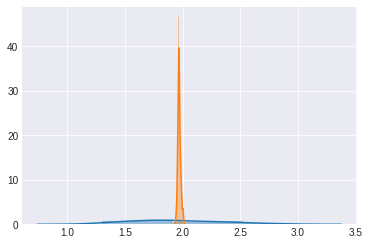

Actual vs predicted


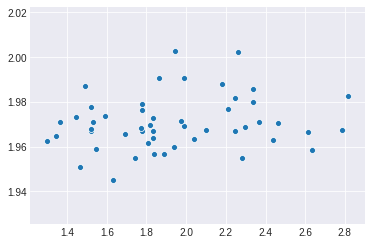

Trying to set attribute `.obs` of view, making a copy.


Number of tokens in training set = 53033.0
Sparsity = 0.913
1.0 1.0
50 100


Finished [100%]: Average Loss = 281.61


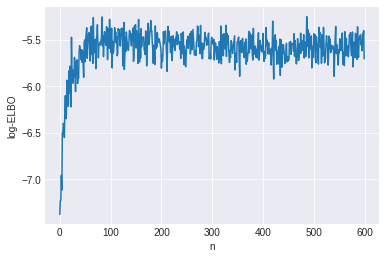

Correlation between actual ambient and predicted ambient counts
0.32096454238729716
 actual ambient and predicted ambient count distributions


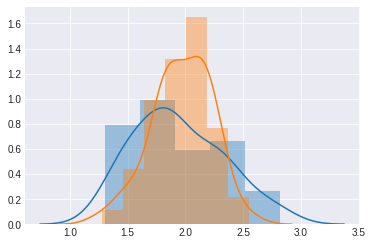

Actual vs predicted


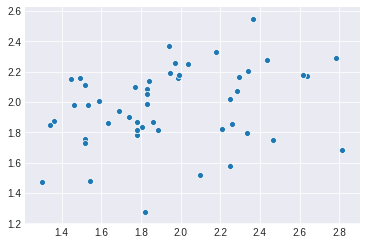

1.0 53033.0
50 100


Finished [100%]: Average Loss = 3,200.1


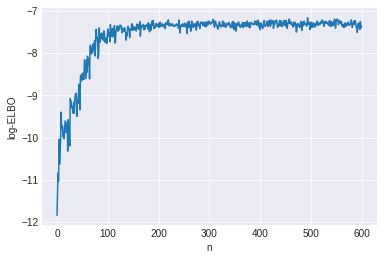

Correlation between actual ambient and predicted ambient counts
0.010039148362607768
 actual ambient and predicted ambient count distributions


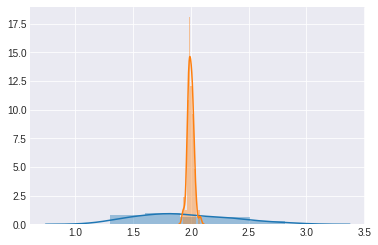

Actual vs predicted


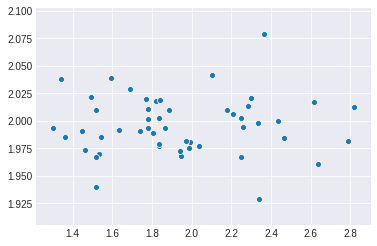

Trying to set attribute `.obs` of view, making a copy.


1.0 50
50 100


Finished [100%]: Average Loss = 327.6


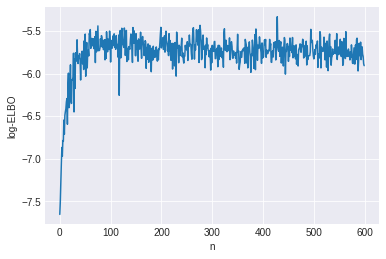

Correlation between actual ambient and predicted ambient counts
0.4173691871899468
 actual ambient and predicted ambient count distributions


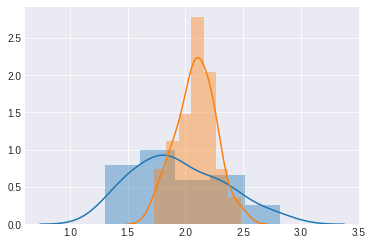

Actual vs predicted


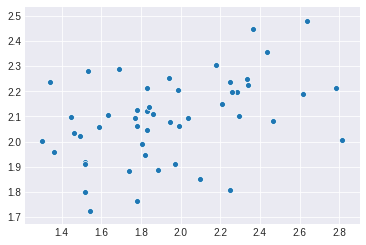

Trying to set attribute `.obs` of view, making a copy.


1.0 100
50 100


Finished [100%]: Average Loss = 359.72


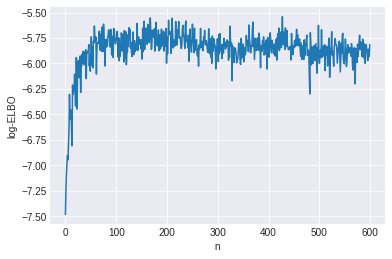

Correlation between actual ambient and predicted ambient counts
0.027571632345152433
 actual ambient and predicted ambient count distributions


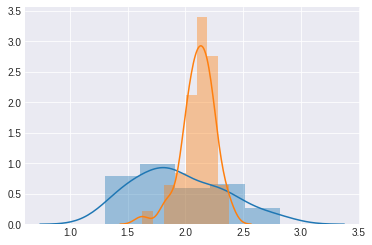

Actual vs predicted


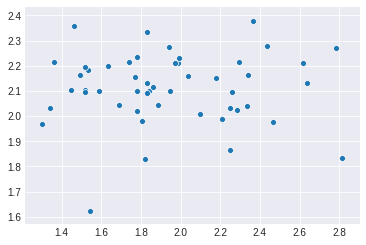

Trying to set attribute `.obs` of view, making a copy.


1.0 2651650.0
50 100


Finished [100%]: Average Loss = 97,838


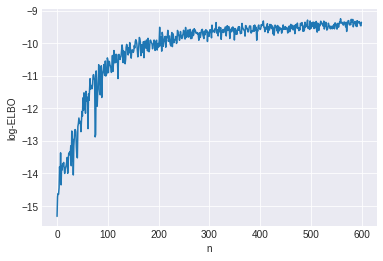

Correlation between actual ambient and predicted ambient counts
0.018156928617539408
 actual ambient and predicted ambient count distributions


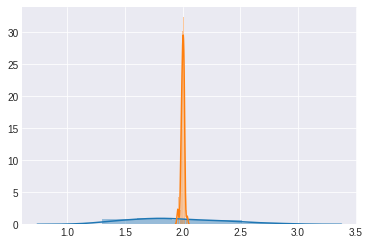

Actual vs predicted


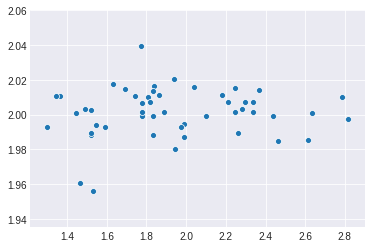

Trying to set attribute `.obs` of view, making a copy.


1.0 265165000.0
50 100


Finished [100%]: Average Loss = 9.14e+06


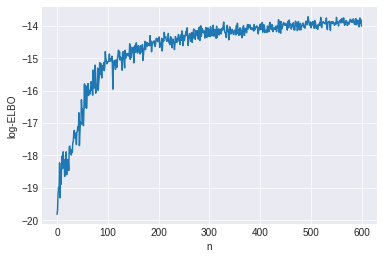

Correlation between actual ambient and predicted ambient counts
0.15774432164021007
 actual ambient and predicted ambient count distributions


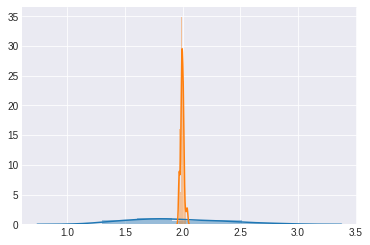

Actual vs predicted


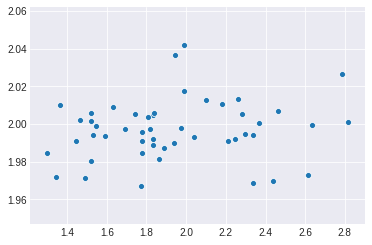

Trying to set attribute `.obs` of view, making a copy.


53033.0 1.0
50 100


Finished [100%]: Average Loss = 2.1794e+05


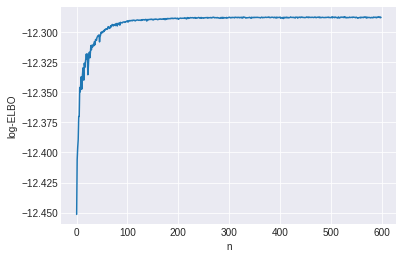

Correlation between actual ambient and predicted ambient counts
-0.01974205730637221
 actual ambient and predicted ambient count distributions


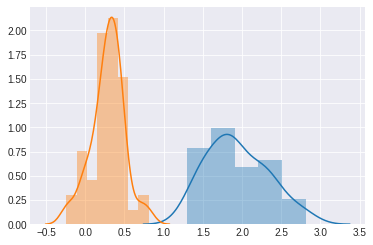

Actual vs predicted


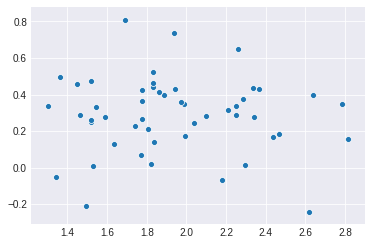

Trying to set attribute `.obs` of view, making a copy.


53033.0 53033.0
50 100


Finished [100%]: Average Loss = 2.2334e+05


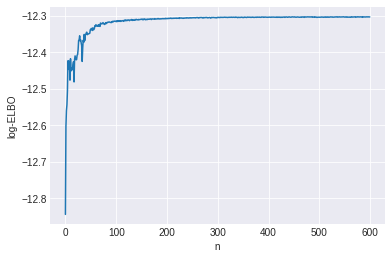

Correlation between actual ambient and predicted ambient counts
-0.10312943317951617
 actual ambient and predicted ambient count distributions


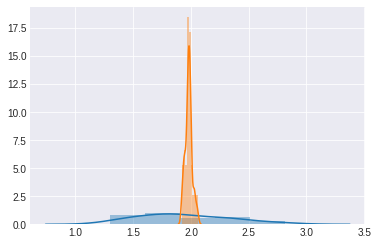

Actual vs predicted


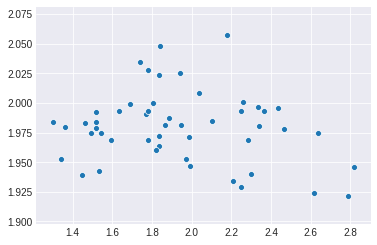

Trying to set attribute `.obs` of view, making a copy.


53033.0 50
50 100


Finished [100%]: Average Loss = 2.1826e+05


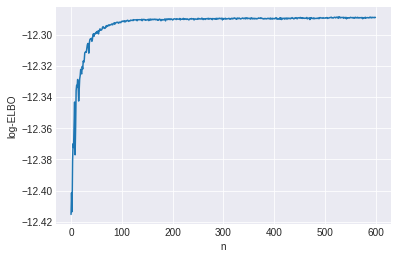

Correlation between actual ambient and predicted ambient counts
0.1700410775293373
 actual ambient and predicted ambient count distributions


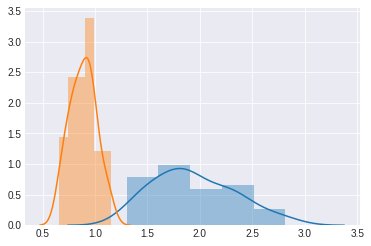

Actual vs predicted


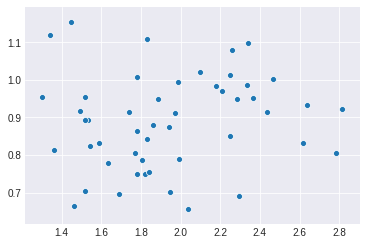

Trying to set attribute `.obs` of view, making a copy.


53033.0 100
50 100


Finished [100%]: Average Loss = 2.186e+05


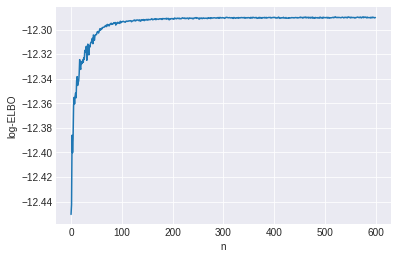

Correlation between actual ambient and predicted ambient counts
0.010903764011062026
 actual ambient and predicted ambient count distributions


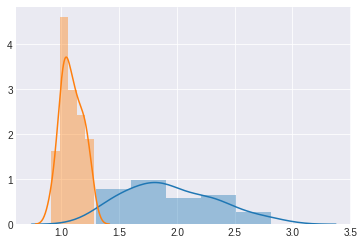

Actual vs predicted


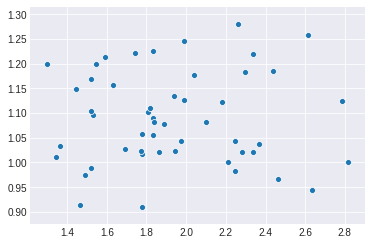

Trying to set attribute `.obs` of view, making a copy.


53033.0 2651650.0
50 100


Finished [100%]: Average Loss = 3.4522e+05


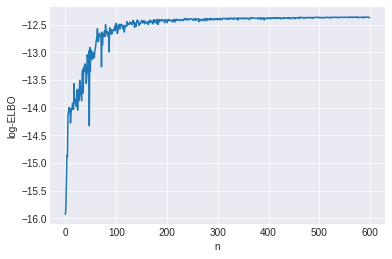

Correlation between actual ambient and predicted ambient counts
-0.20289647217059908
 actual ambient and predicted ambient count distributions


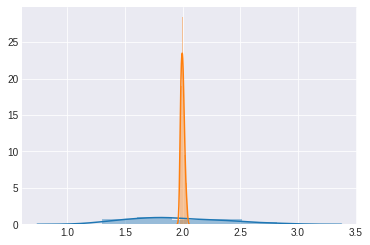

Actual vs predicted


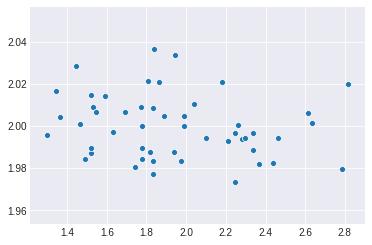

Trying to set attribute `.obs` of view, making a copy.


53033.0 265165000.0
50 100


Finished [100%]: Average Loss = 1.0791e+07


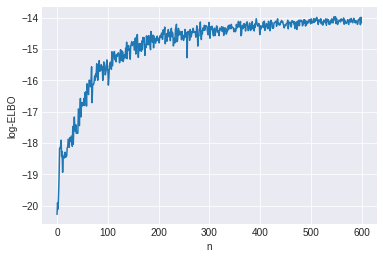

Correlation between actual ambient and predicted ambient counts
-0.03074188972281804
 actual ambient and predicted ambient count distributions


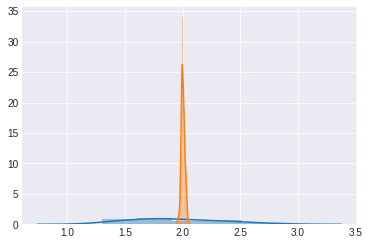

Actual vs predicted


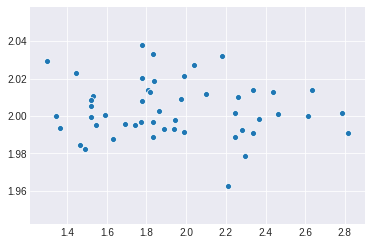

Trying to set attribute `.obs` of view, making a copy.


50 1.0
50 100


Finished [100%]: Average Loss = 510.81


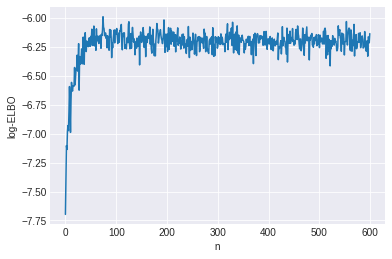

Correlation between actual ambient and predicted ambient counts
0.3306194171283697
 actual ambient and predicted ambient count distributions


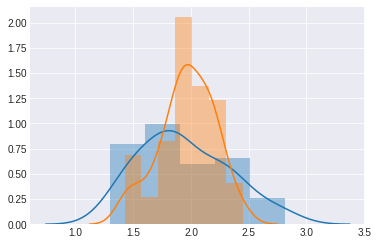

Actual vs predicted


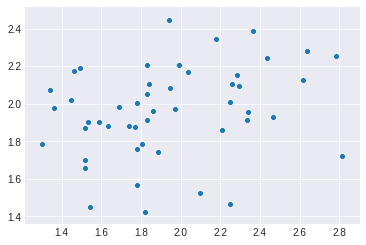

Trying to set attribute `.obs` of view, making a copy.


50 53033.0
50 100


Finished [100%]: Average Loss = 3,511


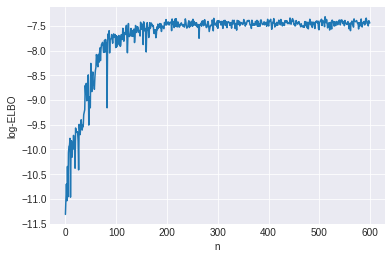

Correlation between actual ambient and predicted ambient counts
0.19300142641606705
 actual ambient and predicted ambient count distributions


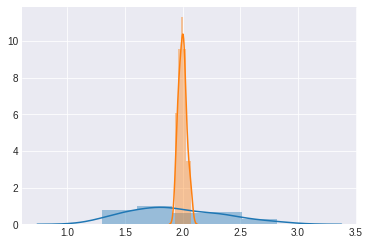

Actual vs predicted


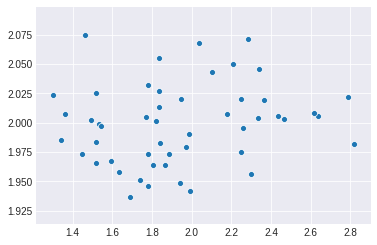

Trying to set attribute `.obs` of view, making a copy.


50 50
50 100


Finished [100%]: Average Loss = 555.29


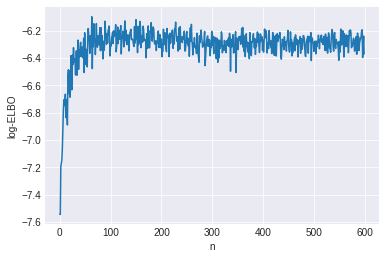

Correlation between actual ambient and predicted ambient counts
0.12022960933783369
 actual ambient and predicted ambient count distributions


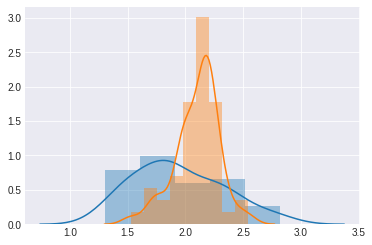

Actual vs predicted


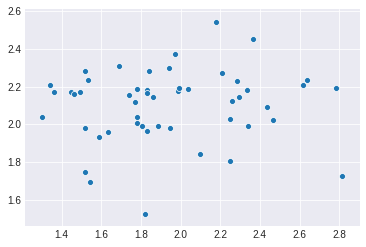

Trying to set attribute `.obs` of view, making a copy.


50 100
50 100


Finished [100%]: Average Loss = 583.69


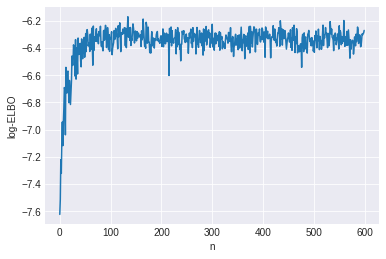

Correlation between actual ambient and predicted ambient counts
0.18132911516193453
 actual ambient and predicted ambient count distributions


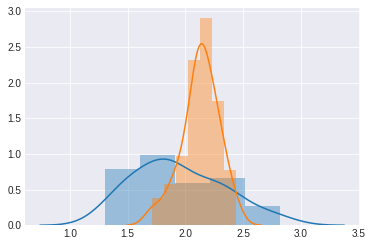

Actual vs predicted


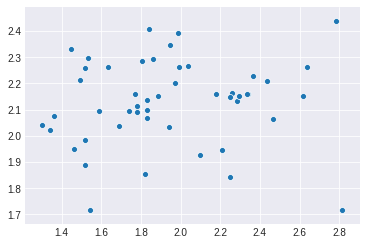

Trying to set attribute `.obs` of view, making a copy.


50 2651650.0
50 100


Finished [100%]: Average Loss = 1.0819e+05


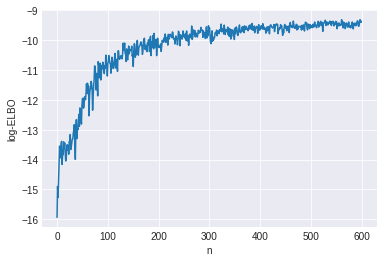

Correlation between actual ambient and predicted ambient counts
0.1975166414691059
 actual ambient and predicted ambient count distributions


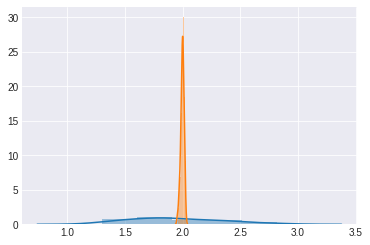

Actual vs predicted


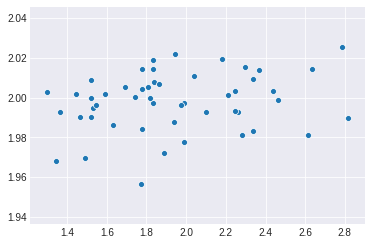

Trying to set attribute `.obs` of view, making a copy.


50 265165000.0
50 100


Finished [100%]: Average Loss = 9.4129e+06


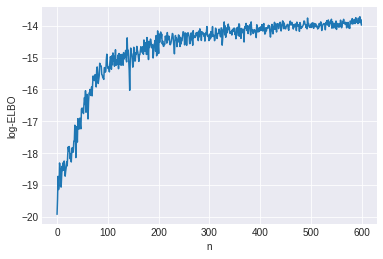

Correlation between actual ambient and predicted ambient counts
-0.13747388810422692
 actual ambient and predicted ambient count distributions


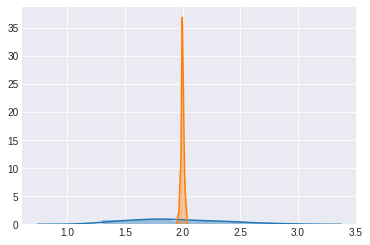

Actual vs predicted


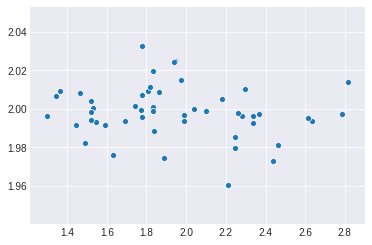

Trying to set attribute `.obs` of view, making a copy.


100 1.0
50 100


Finished [100%]: Average Loss = 747.18


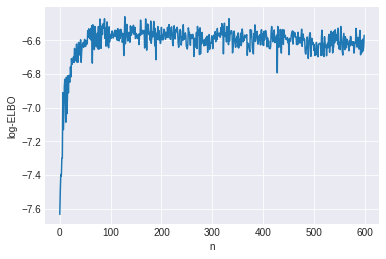

Correlation between actual ambient and predicted ambient counts
0.34262796780134547
 actual ambient and predicted ambient count distributions


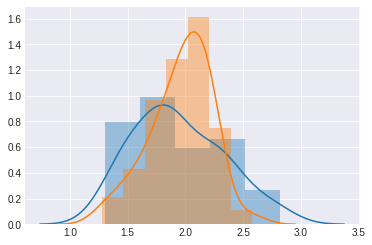

Actual vs predicted


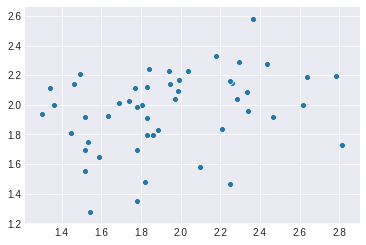

Trying to set attribute `.obs` of view, making a copy.


100 53033.0
50 100


Finished [100%]: Average Loss = 3,846.8


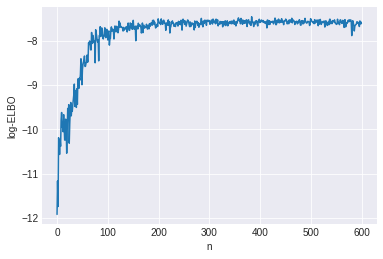

Correlation between actual ambient and predicted ambient counts
-0.18872638237648764
 actual ambient and predicted ambient count distributions


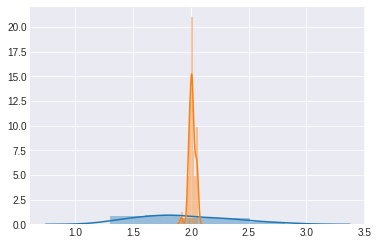

Actual vs predicted


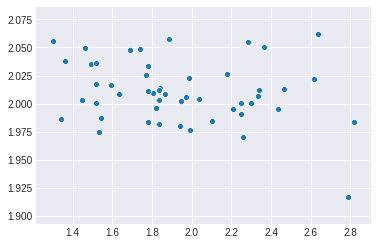

Trying to set attribute `.obs` of view, making a copy.


100 50
50 100


Finished [100%]: Average Loss = 784.58


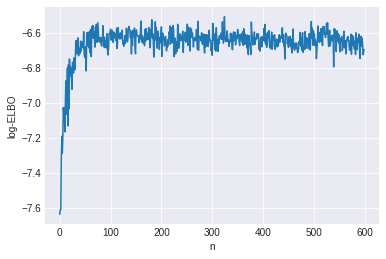

Correlation between actual ambient and predicted ambient counts
0.39253550439823287
 actual ambient and predicted ambient count distributions


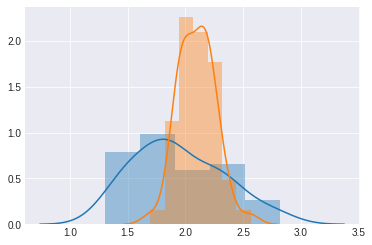

Actual vs predicted


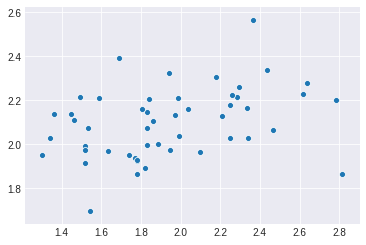

Trying to set attribute `.obs` of view, making a copy.


100 100
50 100


Finished [100%]: Average Loss = 818.37


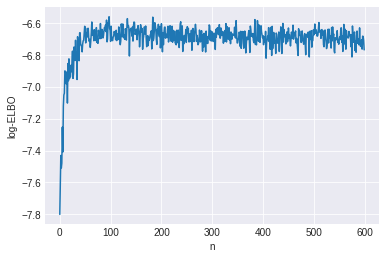

Correlation between actual ambient and predicted ambient counts
0.24146793693219734
 actual ambient and predicted ambient count distributions


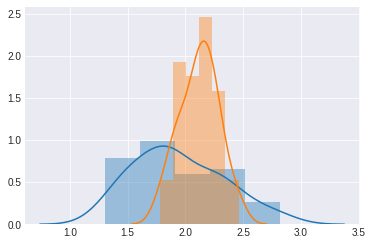

Actual vs predicted


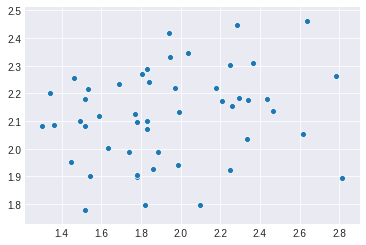

Trying to set attribute `.obs` of view, making a copy.


100 2651650.0
50 100


Finished [100%]: Average Loss = 1.0021e+05


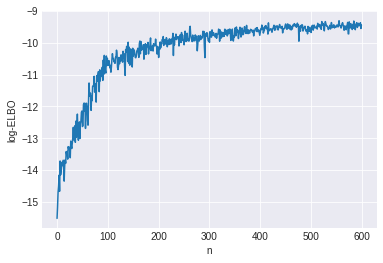

Correlation between actual ambient and predicted ambient counts
0.16101064742325952
 actual ambient and predicted ambient count distributions


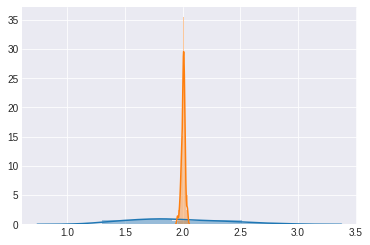

Actual vs predicted


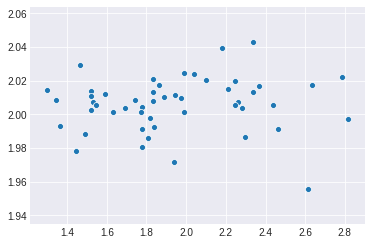

Trying to set attribute `.obs` of view, making a copy.


100 265165000.0
50 100


Finished [100%]: Average Loss = 1.0396e+07


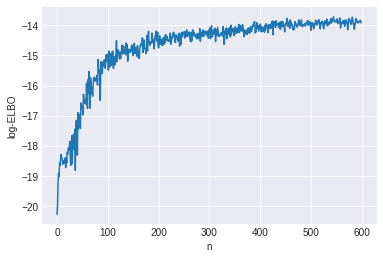

Correlation between actual ambient and predicted ambient counts
0.046833347624605615
 actual ambient and predicted ambient count distributions


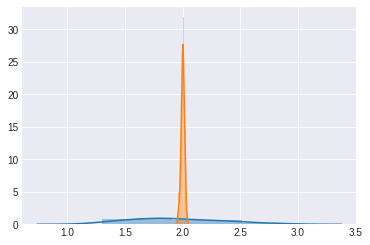

Actual vs predicted


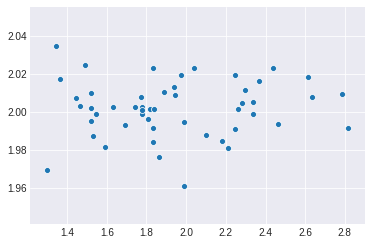

Trying to set attribute `.obs` of view, making a copy.


2651650.0 1.0
50 100


Finished [100%]: Average Loss = 1.0752e+07


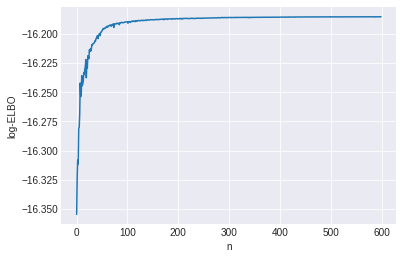

Correlation between actual ambient and predicted ambient counts
0.1023608859364457
 actual ambient and predicted ambient count distributions


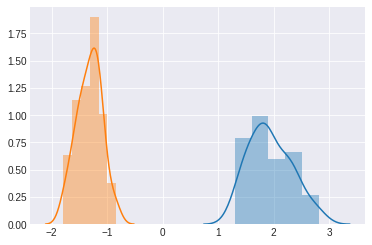

Actual vs predicted


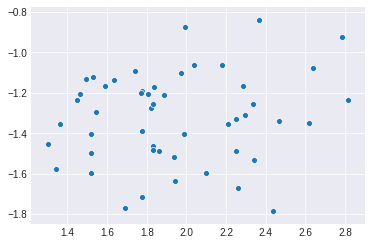

Trying to set attribute `.obs` of view, making a copy.


2651650.0 53033.0
50 100


Finished [100%]: Average Loss = 1.0835e+07


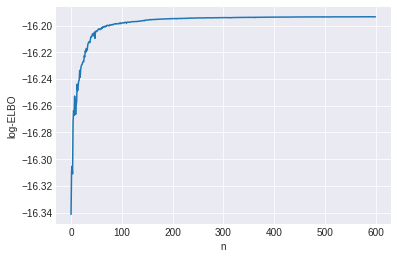

Correlation between actual ambient and predicted ambient counts
0.21082211561476313
 actual ambient and predicted ambient count distributions


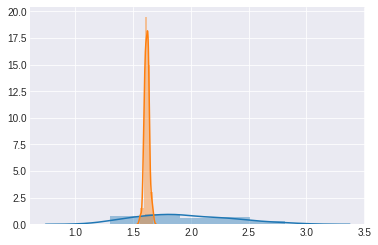

Actual vs predicted


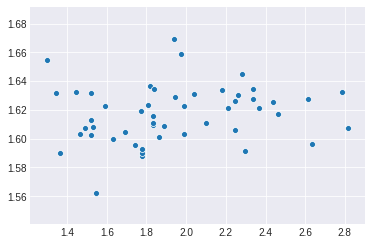

Trying to set attribute `.obs` of view, making a copy.


2651650.0 50
50 100


Finished [100%]: Average Loss = 1.0753e+07


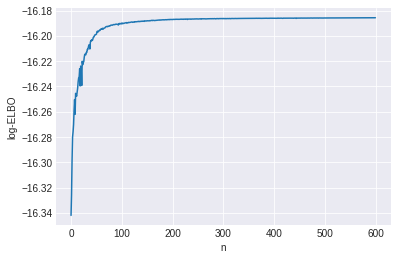

Correlation between actual ambient and predicted ambient counts
-0.022912314684037826
 actual ambient and predicted ambient count distributions


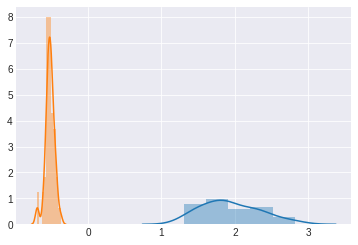

Actual vs predicted


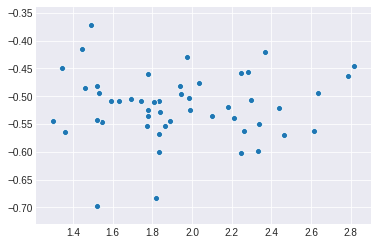

Trying to set attribute `.obs` of view, making a copy.


2651650.0 100
50 100


Finished [100%]: Average Loss = 1.0752e+07


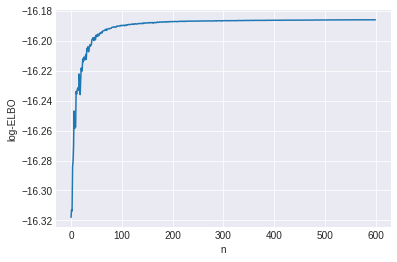

Correlation between actual ambient and predicted ambient counts
0.1445349158999367
 actual ambient and predicted ambient count distributions


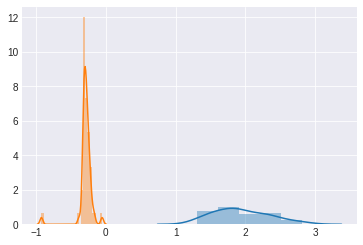

Actual vs predicted


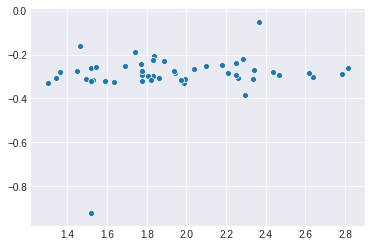

Trying to set attribute `.obs` of view, making a copy.


2651650.0 2651650.0
50 100


Finished [100%]: Average Loss = 1.1057e+07


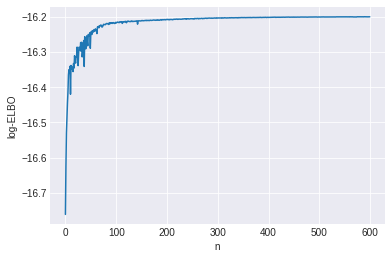

Correlation between actual ambient and predicted ambient counts
0.16759133319205025
 actual ambient and predicted ambient count distributions


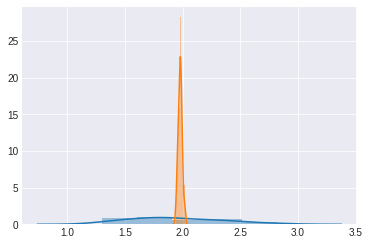

Actual vs predicted


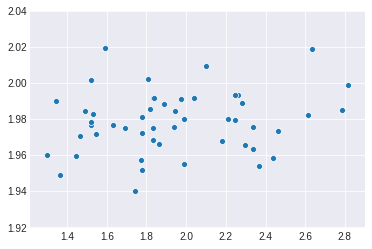

Trying to set attribute `.obs` of view, making a copy.


2651650.0 265165000.0
50 100


Finished [100%]: Average Loss = 2.2596e+07


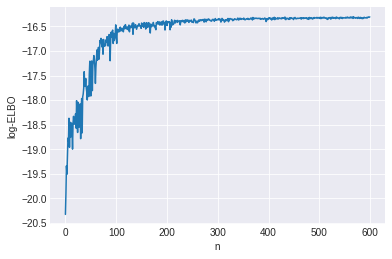

Correlation between actual ambient and predicted ambient counts
0.05226121252879068
 actual ambient and predicted ambient count distributions


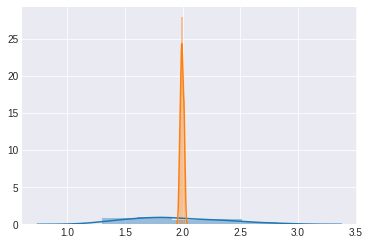

Actual vs predicted


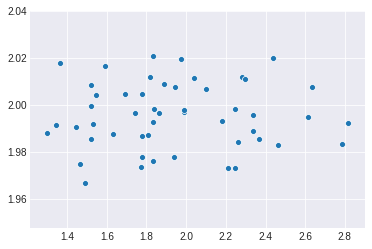

Trying to set attribute `.obs` of view, making a copy.


265165000.0 1.0
50 100


Finished [100%]: Average Loss = 1.076e+09


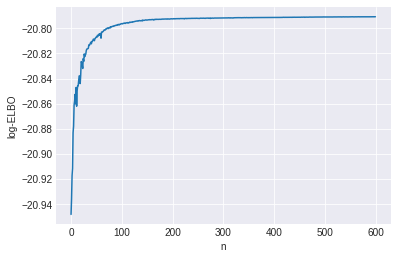

Correlation between actual ambient and predicted ambient counts
0.19833322291486827
 actual ambient and predicted ambient count distributions


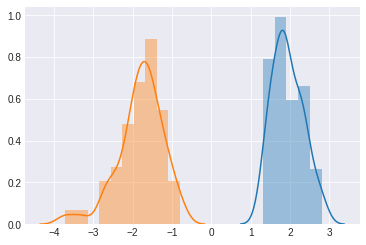

Actual vs predicted


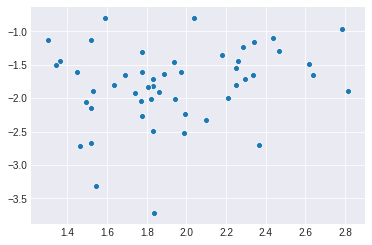

Trying to set attribute `.obs` of view, making a copy.


265165000.0 53033.0
50 100


Finished [100%]: Average Loss = 1.0756e+09


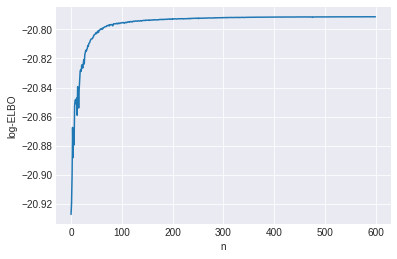

Correlation between actual ambient and predicted ambient counts
0.25395682963209215
 actual ambient and predicted ambient count distributions


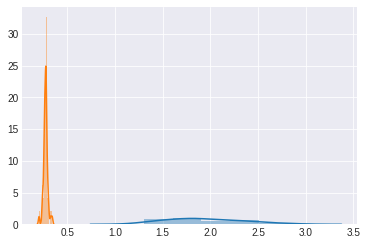

Actual vs predicted


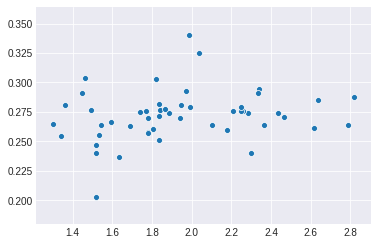

Trying to set attribute `.obs` of view, making a copy.


265165000.0 50
50 100


Finished [100%]: Average Loss = 1.0748e+09


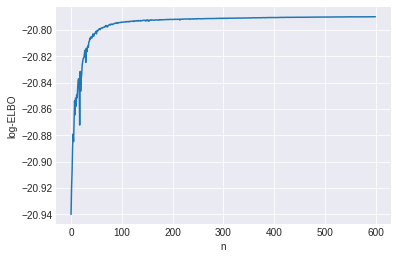

Correlation between actual ambient and predicted ambient counts
0.14751303646683472
 actual ambient and predicted ambient count distributions


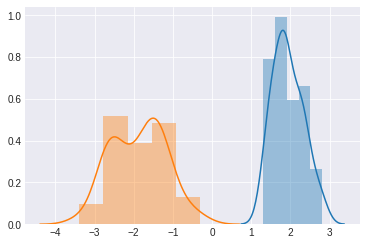

Actual vs predicted


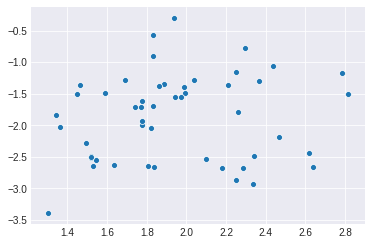

Trying to set attribute `.obs` of view, making a copy.


265165000.0 100
50 100


Finished [100%]: Average Loss = 1.0748e+09


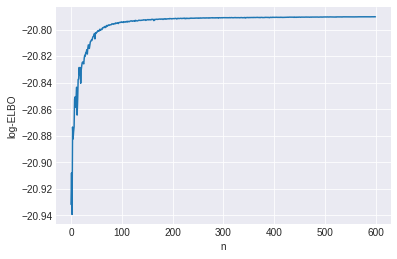

Correlation between actual ambient and predicted ambient counts
0.09208156656037841
 actual ambient and predicted ambient count distributions


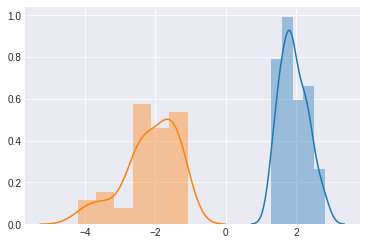

Actual vs predicted


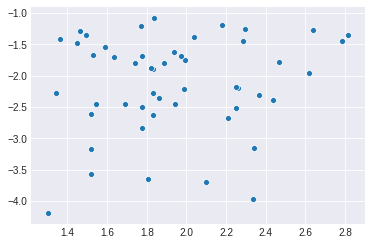

Trying to set attribute `.obs` of view, making a copy.


265165000.0 2651650.0
50 100


Finished [100%]: Average Loss = 1.0811e+09


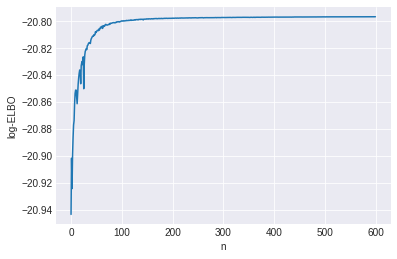

Correlation between actual ambient and predicted ambient counts
0.15942551873442667
 actual ambient and predicted ambient count distributions


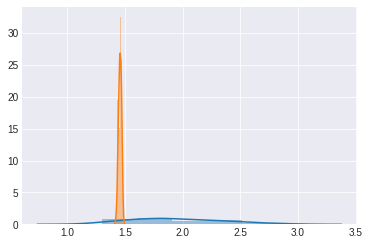

Actual vs predicted


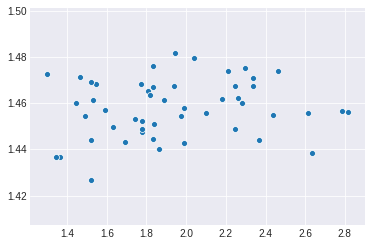

Trying to set attribute `.obs` of view, making a copy.


265165000.0 265165000.0
50 100


In [ ]:
results=[]
for cells in [list(range(50)),list(range(100)),list(range(300)),list(range(500)),list(range(1000))]:
    for genes in [list(range(50)),list(range(100)),list(range(300)),list(range(500))]:
        #cells=list(range(500))
        #genes=list(range(500))
        adata=freshadata.copy()
        adata._inplace_subset_obs(cells)
        adata._inplace_subset_var(genes)
        ambcounts=np.array(ambcountsorig)[cells]
        phiAmbient=np.array(phiAmbientOrig)[genes]
        feature_names=list(adata.var.index)
        tf=adata.X
        n_tokens = np.sum(tf[tf.nonzero()])
        print('Number of tokens in training set = {}'.format(n_tokens))
        print('Sparsity = {}'.format(
            len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))
        factors=[1.0,adata.X.sum(),adata.shape[0],adata.shape[1],adata.X.sum()*adata.shape[0],adata.X.sum()*adata.shape[0]*adata.shape[1]]
        for alph,ALPH in enumerate(factors):
            for bet, BET in enumerate(factors):
                print(ALPH,BET)
                model1 = pm.Model()
                (D,V)=tf.shape
                print(D,V)
                #Alpha prior for theta topic over cell distribution
                alpha = np.ones((D, K))*1
                #alpha[:,K-1]=(10**ambmu)/tf.sum(1).A1
                #beta prior for gene over topic distribution
                beta = np.ones((K-1, V))*1
                sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
                tt.cast(sparse_array,'int32')
                rowsums=shared(np.sum(tf,axis=1).T)
                sumall=shared(np.sum(tf))

                def lognormpdf(mean, sd):
                    import math
                    def internalnorm(x):
                        var = float(sd)**2
                        denom = tt.log(2*math.pi*var)*.5
                        num = -(x-float(mean))**2/(2*var)
                        return(num-denom)
                    return internalnorm
                ambient=lognormpdf(ambmu,ambsd)
                
                def _norm_logpdf(x):
                    _norm_pdf_logC=tt.log(tt.sqrt(2*np.pi))
                    return -x**2 / 2.0 - _norm_pdf_logC

                def lognormpdf(mean, sd,df):
                    import math
                    def internalnorm(x):
                        df2=x.shape[1]-1
                        sd2=x.std()
                        Fstat=sd2/sd
                        n = 1.0 * df
                        m = 1.0 * df2
                        lPx = m/2 * tt.log(m) + n/2 * tt.log(n) + (n/2 - 1) * tt.log(Fstat)
                        lPx -= ((n+m)/2) * np.log(m + n*Fstat) + (tt.gammaln(n/2)+tt.gammaln(m/2)-tt.gammaln((n+m)/2))
                        #fp=scipy.stats.f.logpdf(Fstat,df,df2)
                        pooledSE = tt.sqrt(sd**2/df + sd2**2/df2)
                        z = (tt.mean(x)-mean)/pooledSE
                        pval = _norm_logpdf(z)
                        var = float(sd)**2
                        denom = tt.log(2*math.pi*var)*.5
                        num = -(x-float(mean))**2/(2*var)
                        return(lPx+pval)#+tt.sum(num-denom))
                    return internalnorm
                #ambient=lognormpdf(ambmu,ambsd,90000)


                def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
                    if phiAmbient is not None:
                        phi=tt.concatenate([phi,phiAmbient],axis=0)
                    else:
                        phi=phi
                    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-10)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-10),axis=1).ravel()                                                                  
                    ambientll=ambient(tt.log10((rowsums+1e-10)*(theta[:,theta.shape[1]-1]+1e-10)))
                    #return(tt.sum(ll)+ ambientll)
                    return((ALPH*(tt.sum(ll)/sumall) + (tt.sum(ambientll)/adata.shape[0])*BET))

                with model1: 
                    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9))#.astype('float32')
                    #Kth topic is fixed as ambient distribution, therefore not learned
                    phi = pm.Dirichlet("phi", a=beta, shape=(K-1, V), transform=t_stick_breaking(1e-9))#.astype('float32')
                    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
                        phi=phi,
                        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

                eta = .2
                s = shared(eta)

                with model1:    
                    #Inference learning methods appear about equivalent
                    #inference = pm.ADVI()
                    #inference = pm.FullRankADVI()
                    inference=pm.variational.NFVI()
                    approx = pm.fit(n=600,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')],progressbar=False)

                tr1 = approx.sample(draws=200)
                advi_elbo = pd.DataFrame(
                    {'log-ELBO': -np.log(approx.hist),
                     'n': np.arange(approx.hist.shape[0])})
                plt.clf()
                sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
                plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
                plt.show()
                theta=tr1['theta'].mean(0)
                print('Correlation between actual ambient and predicted ambient counts')
                print(scipy.stats.spearmanr(np.log10(ambcounts),np.log10(tf.sum(1).A1*theta[:,9]))[0])
                print(' actual ambient and predicted ambient count distributions')
                sns.distplot(np.log10(ambcounts))
                sns.distplot(np.log10(tf.sum(1).A1*theta[:,9]))
                plt.show()
                results.append([alph,bet,len(cells),len(genes),scipy.stats.spearmanr(np.log10(ambcounts),np.log10(tf.sum(1).A1*theta[:,9]))[0]])
                print('Actual vs predicted')
                sns.scatterplot(np.log10(ambcounts),np.log10(tf.sum(1).A1*theta[:,9]))
                plt.show()
                theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
                for i in range(theta.shape[1]):
                    adata.obs['lda_'+str(i)]=theta[:,i].X

                phi=tr1['phi'].mean(0)
                phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

                for i in range(phi.shape[0]):
                    adata.var['lda_'+str(i)]=0
                    adata.var.loc[:,'lda_'+str(i)]=phi[i,:].X
                adata.var['lda_'+str(K-1)]=phiAmbient
                #Resort indices so the ones we're subtracting from are listed first
                adata.var.loc[:,'lda_'+str(K-1)]=[phiAmbientDict[x] for x in adata.var.index]
                fullinds=list(adata.var.index)
                [fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
                adata=adata[:,fullinds]
           
                '''adata.raw=adata
                #sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
                sc.pp.filter_cells(adata,min_counts=0,inplace=True)
                sc.pp.normalize_total(adata, target_sum=1e4)
                sc.pp.log1p(adata)
                sc.pp.highly_variable_genes(adata,n_top_genes=min(adata.shape[1],4000),inplace=True)
                sc.pp.scale(adata, max_value=10)
                sc.pp.pca(adata)
                sc.pp.neighbors(adata)
                sc.tl.umap(adata)
                sc.tl.leiden(adata)
                sc.pl.umap(adata, color=['leiden'])
                adata.X=adata.raw.X
                sc.pl.umap(adata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'])'''


In [15]:
df=pd.DataFrame(results)


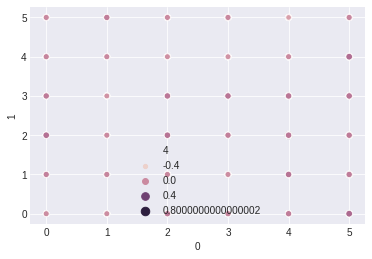

In [16]:
sns.scatterplot(0,1,size=4,hue=4,data=df)

In [17]:
df

,0,1,2,3,4
0,0,0,50,50,-0.132360
1,0,1,50,50,0.038325
2,0,2,50,50,-0.022860
3,0,3,50,50,-0.068773
4,0,4,50,50,0.119777
5,0,5,50,50,-0.007732
6,1,0,50,50,0.062818
7,1,1,50,50,-0.103929
8,1,2,50,50,-0.004995
9,1,3,50,50,-0.236817


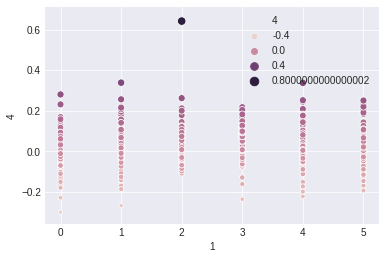

In [19]:
sns.scatterplot(1,4,size=4,hue=4,data=df)

In [26]:
np.argsort(df[4])

0       96
1      151
2        9
3       36
4      118
5      226
6      137
7      127
8       55
9       84
10      46
11      24
12      91
13     263
14      78
15     213
16      40
17     186
18      13
19     413
20      43
21      85
22      25
23     145
24      48
25       0
26     207
27     397
28     165
29     185
      ... 
690     88
691    495
692    103
693     81
694     41
695    113
696    458
697    140
698    211
699    608
700    107
701    171
702    241
703     70
704    104
705    247
706     99
707     49
708    131
709     89
710    102
711    106
712    275
713    142
714     61
715    278
716     66
717    286
718     67
719     26
Name: 4, Length: 720, dtype: int64

In [28]:
df.iloc[26,:]

0     4.000000
1     2.000000
2    50.000000
3    50.000000
4     0.642013
Name: 26, dtype: float64

In [31]:
df.iloc[66,:]

0      5.000000
1      0.000000
2     50.000000
3    100.000000
4      0.280088
Name: 66, dtype: float64